In [27]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
import xesmf as xe
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from netCDF4 import Dataset

from numpy.linalg import svd
from scipy.stats import norm
from scipy.linalg import solve_triangular
import scipy.linalg as la
from scipy.linalg import det
from scipy.linalg import eigh 

import os

import pandas as pd
import matplotlib.ticker as mticker

In [2]:
dir_data = '/scratch/asarker3/clim680/conv_data_181/'

In [3]:
# File path
filename_cntl = f"{dir_data}picontrol2.nc"
ncin_cntl = xr.open_dataset(filename_cntl)
ncin_cntl

/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/backends/plugins.py:65: RuntimeWarning: Engine 'gini' loading failed:
cannot import name 'deprecated' from 'typing_extensions' (/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/typing_extensions.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)

<xarray.Dataset>
Dimensions:  (time: 3600, lat: 181, lon: 361)
Coordinates:
  * time     (time) object 3550-01-16 12:00:00 ... 3849-12-16 12:00:00
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    tos      (time, lat, lon) float32 ...

In [4]:
annual_mean_cntl = ncin_cntl.mean(dim='time')

In [5]:
annual_mean_cntl

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 361)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    tos      (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan

In [6]:
# File path
filename_hist = f"{dir_data}tos3.nc"
ncin_hist = xr.open_dataset(filename_hist)
ncin_hist

<xarray.Dataset>
Dimensions:  (time: 1980, lat: 181, lon: 361)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    tos      (time, lat, lon) float32 ...

In [7]:
annual_mean_hist = ncin_hist.groupby('time.year').mean(dim='time')
max_value_hist = annual_mean_hist.max()
min_value_hist = annual_mean_hist.min()
print(f"Maximum value: {max_value_hist}")
print(f"Minimum value: {min_value_hist}")

Maximum value: <xarray.Dataset>
Dimensions:  ()
Data variables:
    tos      float64 30.85
Minimum value: <xarray.Dataset>
Dimensions:  ()
Data variables:
    tos      float64 -1.929


In [8]:
result = annual_mean_hist - annual_mean_cntl

In [9]:
result 

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 361, year: 165)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
Data variables:
    tos      (year, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan

In [22]:
fig_folder = '/home/asarker3/clim680/project/figures'

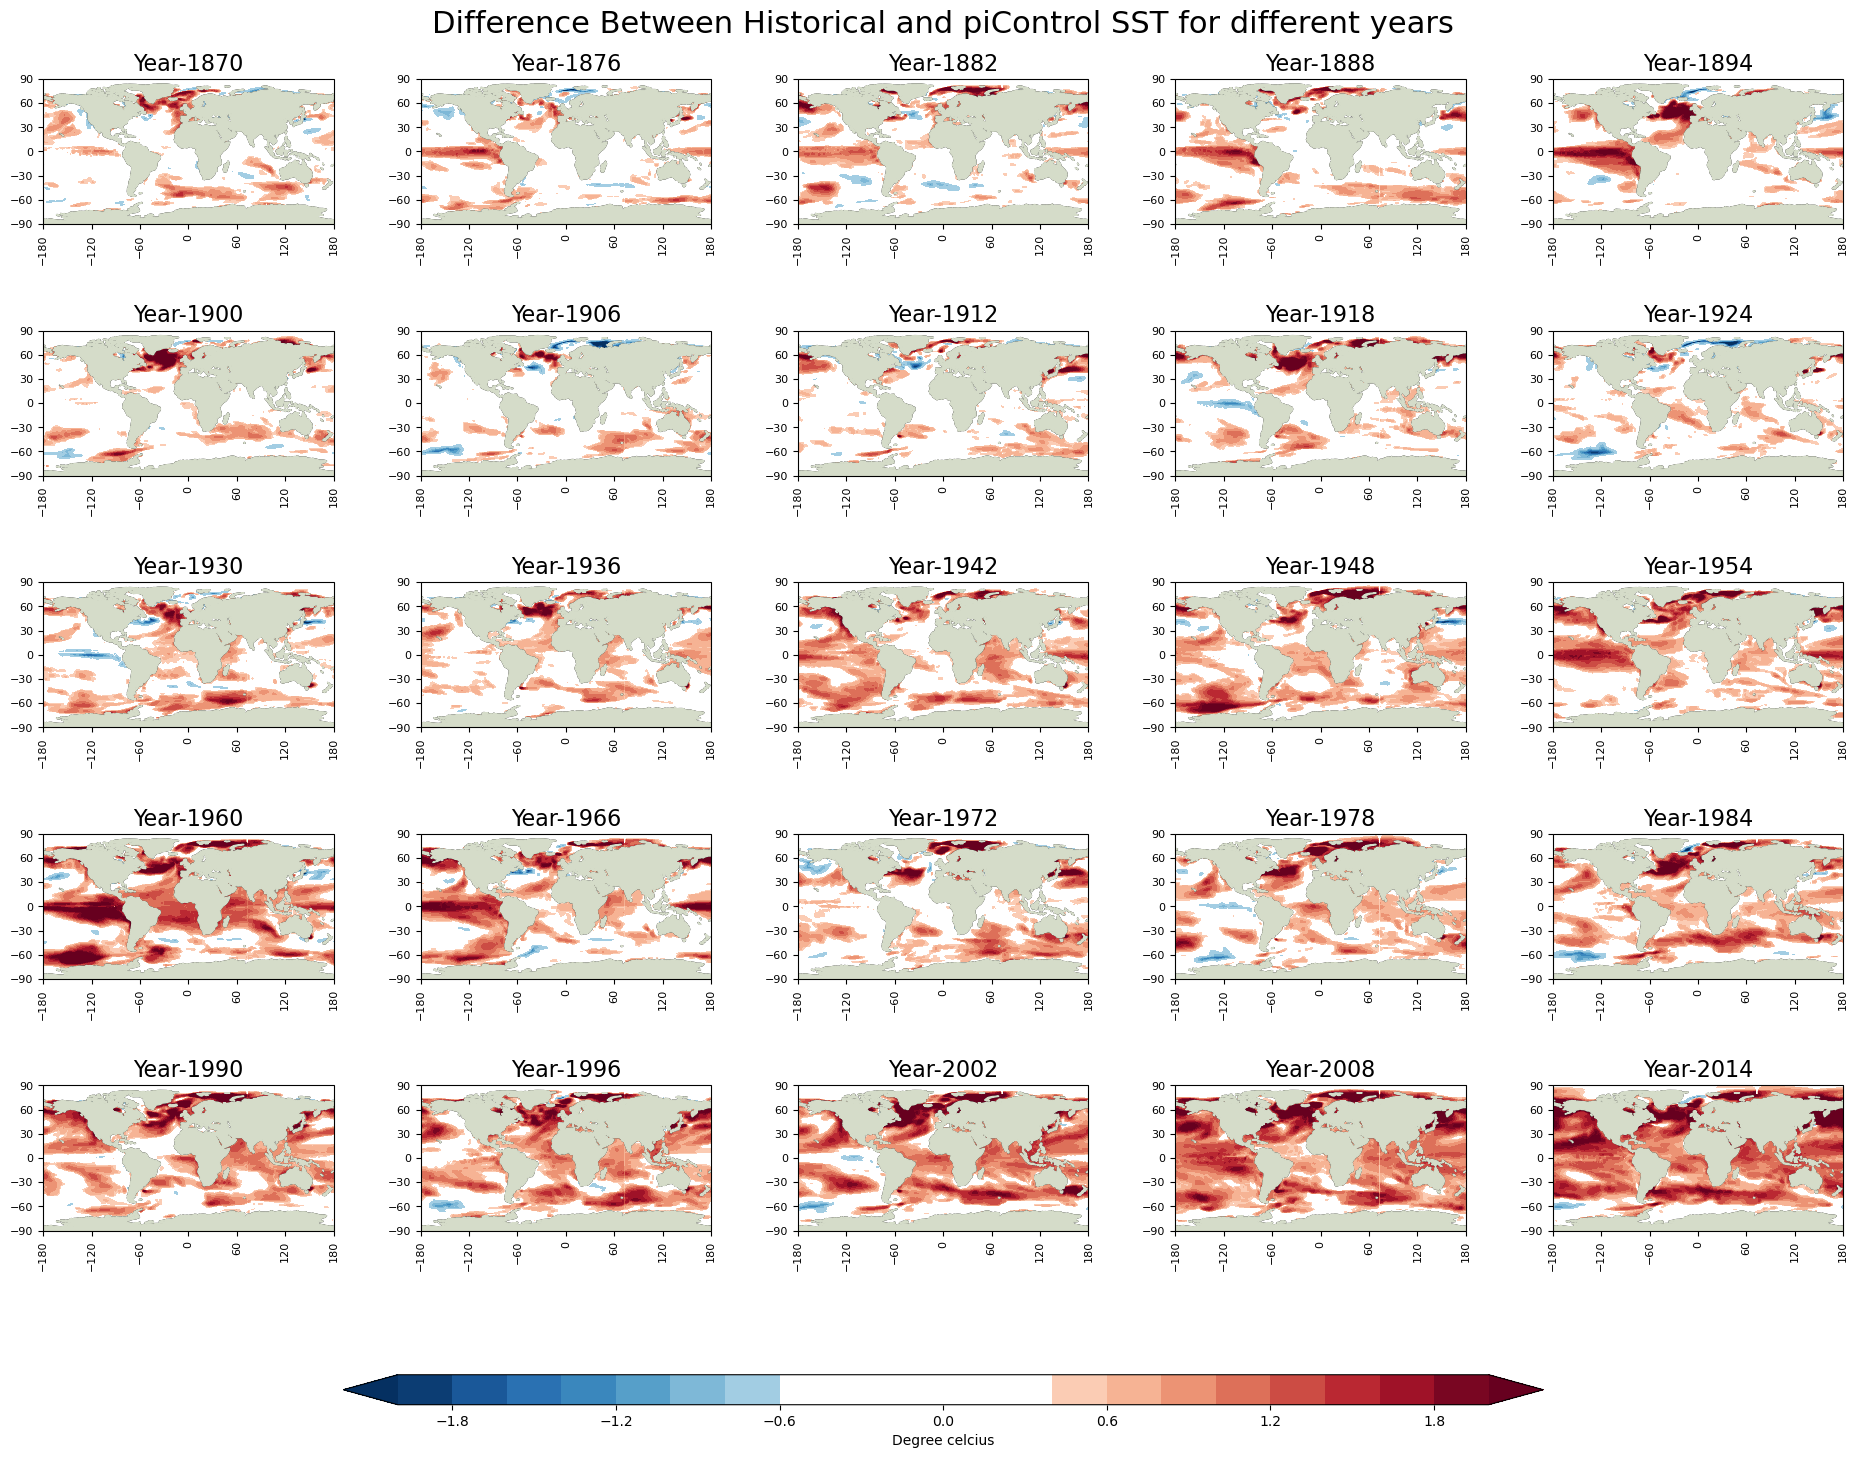

In [28]:
year_index = np.sort(np.linspace(164, 164 - (24 * 6), 25))

# Custom normalization to highlight the range
class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)
    
    def __call__(self, value, clip=None):
        # Shift the colormap so the midpoint is mapped to 0
        normalized = np.ma.masked_array(value, mask=(value > -0.5) & (value < 0.5))
        normalized.fill_value = 0
        return super().__call__(normalized, clip)

# Create the figure and subplots
fig, axs = plt.subplots(nrows=5, ncols=5, 
                        subplot_kw={'projection': ccrs.PlateCarree()}, 
                        figsize=(20, 15))

# Flatten axs to easily iterate over subplots
axs = axs.flatten()

# Define colormap and levels
cmap = plt.get_cmap('RdBu_r')
norm = MidpointNormalize(vmin=-2, vmax=2, midpoint=0)

# Loop through each random timestep and plot
for i, timestep in enumerate(year_index):
    timestep = int(timestep)
    # Select data for the specific timestep
    data = result['tos'].isel(year=timestep)
    
    # Set values between -0.5 and 0.5 to zero
    data = data.where((data <= -0.5) | (data >= 0.5), 0)
    
    # Add cyclic point to avoid a gap in the map
    data, lons = add_cyclic_point(data, coord=result['lon'])
    
    # Plot data on the current axis
    cs = axs[i].contourf(lons, result['lat'], data, 
                         levels=np.linspace(-2, 2, 21), 
                         transform=ccrs.PlateCarree(),
                         cmap=cmap, norm=norm, extend='both')
    actual_year = result['year'].values[timestep]
    # Add a title for each subplot
    axs[i].set_title(f"Year-{actual_year}", fontsize=16)
    
    # Add coastlines and features
    axs[i].coastlines()
    axs[i].add_feature(cfeature.LAND, zorder=2, color='#D5DCC9')
    
    # Longitude and latitude ticks
    axs[i].set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    axs[i].set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    axs[i].tick_params(axis='x', rotation=90, labelsize=8)
    axs[i].tick_params(axis='y', labelsize=8)

# Adjust layout to accommodate colorbar
fig.subplots_adjust(bottom=0.15, top=0.95, left=0.05, right=0.95, wspace=0.3, hspace=0.3)

# Add a colorbar at the bottom
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label="Degree celcius")

# Add a main title
plt.suptitle('Difference Between Historical and piControl SST for different years', fontsize=22)

fig.savefig(os.path.join(fig_folder, 'climatology'))
plt.show()
